In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,Conv1D,Flatten,MaxPooling1D,LSTM
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
from scikeras.wrappers import KerasClassifier, KerasRegressor
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Identify stock data to grab by ticker
ticker = 'AAPL'

start_date=datetime.datetime(2016,1,6)
end_date=datetime.datetime(2021,1,5)

In [3]:
import pandas as pd 
import numpy as np
import yfinance as yf
from ta import add_all_ta_features
from sklearn.linear_model import LinearRegression

def load_and_prepare(ticker, start_date, end_date):
    # Fetch historical stock data
    df = yf.download(ticker, start=start_date , end=end_date)

    # Calculate daily returns
    df['returns'] = df['Adj Close'].pct_change()

    # Fetch market data (e.g., S&P 500)
    market_data = yf.download('^GSPC', start=df.index.min(), end=df.index.max())
    market_data['market_returns'] = market_data['Adj Close'].pct_change()

    # Combine stock and market data
    merged_data = pd.merge(df, market_data[['market_returns']], left_index=True, right_index=True, how='inner')

    # Drop rows with missing values
    merged_data.dropna(inplace=True)

    # Initialize lists to store alpha and beta values
    alpha_values = []
    beta_values = []

    # Set up X and y for linear regression
    X = merged_data['market_returns'].values.reshape(-1, 1)
    y = merged_data['returns'].values

    # Iterate through the data to calculate alpha and beta for each day
    for i in range(len(merged_data)):
        X_i = X[:i + 1]
        y_i = y[:i + 1]

        # Fit linear regression model
        model = LinearRegression()
        model.fit(X_i, y_i)

        # Extract alpha and beta for the current day
        alpha_i = model.intercept_
        beta_i = model.coef_[0]

        alpha_values.append(alpha_i)
        beta_values.append(beta_i)

    # Add alpha and beta columns to the DataFrame
    merged_data['alpha'] = alpha_values
    merged_data['beta'] = beta_values

    # Drop columns not needed for the final result
    merged_data.drop(['returns', 'market_returns'], axis=1, inplace=True)

    # Add technical analysis features
    merged_data = add_all_ta_features(merged_data, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

    # Calculate target and target class
    merged_data['target'] = ((merged_data['Close'] - merged_data['Open']) / merged_data['Open']) * 100
    merged_data['target'] = merged_data['target'].shift(-1)
 
    merged_data['target_class'] = np.where(merged_data['target'] < 0, 0, 1)
    
    merged_data['target_next_close'] = merged_data['Close'].shift(-1)

    # Drop rows with missing values
    merged_data.dropna(inplace=True)

    return merged_data




In [4]:
df = load_and_prepare('AAPL', "2010-01-01" , "2024-01-01")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


/Users/fauzanarif/Bootcamp/ds-capstone/.venv/lib/python3.11/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/Users/fauzanarif/Bootcamp/ds-capstone/.venv/lib/python3.11/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [5]:
df

,Open,High,Low,Close,Adj Close,Volume,alpha,beta,volume_adi,volume_obv,...,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,target,target_class,target_next_close
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.490200,601904800,0.001729,0.000000,-2.057486e+07,601904800,...,0.000000,0.000000,0.000000,0.000000,-87.218709,0.000000,0.000000,-1.590632,0,7.534643
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.386965,552160000,-0.019649,6.861476,-5.185037e+08,49744800,...,0.000000,-0.663342,-0.132668,-0.530674,-1.590632,-1.603419,-1.590632,-0.552545,0,7.520714
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.375157,477131200,-0.017330,4.693584,-5.007164e+08,-427386400,...,0.000000,-2.209120,-0.547959,-1.661162,-0.184871,-0.185042,-1.772563,0.798858,1,7.570714
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.417541,447610800,-0.015755,5.087215,-5.919977e+07,20224400,...,0.000000,-3.855405,-1.209448,-2.645957,0.664833,0.662633,-1.119514,-1.264089,0,7.503929
2010-01-11,7.600000,7.607143,7.444643,7.503929,6.360928,462229600,-0.016622,5.281366,-1.841516e+08,-442005200,...,0.000000,-4.942129,-1.955984,-2.986145,-0.882147,-0.886061,-1.991786,-0.702707,0,7.418571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-20,196.899994,197.679993,194.830002,194.830002,194.830002,52242800,0.000608,1.112890,2.825088e+10,16870127800,...,2.850662,5.478232,4.664745,0.813486,-1.071393,-1.077173,2444.658960,-0.724127,0,194.679993
2023-12-21,196.100006,197.080002,193.500000,194.679993,194.679993,46482500,0.000605,1.112596,2.823504e+10,16823645300,...,0.651429,3.229345,4.377665,-1.148320,-0.076995,-0.077025,2442.699703,-0.809502,0,193.600006
2023-12-22,195.179993,195.410004,192.970001,193.600006,193.600006,37122800,0.000603,1.112573,2.821709e+10,16786522500,...,0.665557,0.040713,3.510275,-3.469562,-0.554750,-0.556294,2428.594085,-0.289240,0,193.050003


In [6]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'alpha', 'beta',
       'volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi', 'volume_mfi',
       'volume_em', 'volume_sma_em', 'volume_vpt', 'volume_nvi', 'volume_vwap',
       'volatility_atr', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kcw', 'volatility_kcp', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'volatility_dcm',
       'volatility_dcw', 'volatility_dcp', 'volatility_ui', 'trend_macd',
       'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow', 'trend_adx',
       'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
       'trend_mass_index', 'trend_cci', 'trend_dpo', '

In [7]:
df["rapp"]=df["Close"].divide(df['Close'].shift(1)) # Should be the close of the previous close

In [8]:
df["mv_avg_short"]= df["Close"].rolling(window=5).mean()
df["mv_avg_long"]= df["Close"].rolling(window=50).mean()

In [9]:
df=df.iloc[50:,:] # WARNING: DO IT JUST ONE TIME!
print(df.index)

DatetimeIndex(['2010-03-18', '2010-03-19', '2010-03-22', '2010-03-23',
               '2010-03-24', '2010-03-25', '2010-03-26', '2010-03-29',
               '2010-03-30', '2010-03-31',
               ...
               '2023-12-13', '2023-12-14', '2023-12-15', '2023-12-18',
               '2023-12-19', '2023-12-20', '2023-12-21', '2023-12-22',
               '2023-12-26', '2023-12-27'],
              dtype='datetime64[ns]', name='Date', length=3469, freq=None)


In [10]:
len(df)

3469

In [11]:
df = df.reset_index()

In [12]:
from sklearn.model_selection import train_test_split

# Assuming 'df' is your DataFrame
train, test = train_test_split(df, test_size=600, shuffle=False)

# Display the shapes of the resulting DataFrames
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (2869, 98)
Test shape: (600, 98)


In [13]:
# This function returns the total percentage gross yield and the annual percentage gross yield

def yield_gross(df,v):
    prod=(v*df["rapp"]+1-v).prod()
    n_years=len(v)/252
    return (prod-1)*100,((prod**(1/n_years))-1)*100

In [14]:
def create_window(data, window_size = 1):    
    data_s = data.copy()
    for i in range(window_size):
        data = pd.concat([data, data_s.shift(-(i + 1))], axis = 1)
        
    data.dropna(axis=0, inplace=True)
    return(data)

2024-01-19 11:18:52.283560: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-01-19 11:18:52.283603: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-01-19 11:18:52.283615: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-01-19 11:18:52.283657: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-19 11:18:52.283673: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2024-01-19 11:18:54.883387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 10s 247ms/step - loss: 0.0033 - val_loss: 0.0064
Epoch 2/100
15/15 [==============================] - 0s 21ms/step - loss: 0.0477 - val_loss: 0.2955
Epoch 3/100
15/15 [==============================] - 0s 20ms/step - loss: 0.0017 - val_loss: 0.0105
Epoch 4/100
15/15 [==============================] - 0s 19ms/step - loss: 0.0078 - val_loss: 0.0358
Epoch 5/100
15/15 [==============================] - 0s 20ms/step - loss: 0.0122 - val_loss: 0.0593
Epoch 6/100
15/15 [==============================] - 0s 20ms/step - loss: 0.0396 - val_loss: 0.4522
Epoch 7/100
15/15 [==============================] - 0s 20ms/step - loss: 0.0087 - val_loss: 0.0410
Epoch 8/100
15/15 [==============================] - 0s 19ms/step - loss: 0.0157 - val_loss: 0.0361
Epoch 9/100
15/15 [==============================] - 0s 20ms/step - loss: 0.0439 - val_loss: 0.5046
Epoch 10/100
15/15 [==============================] - 0s 24ms/step - loss: 0.0225 - val_loss: 0.2976
Epoch 11/

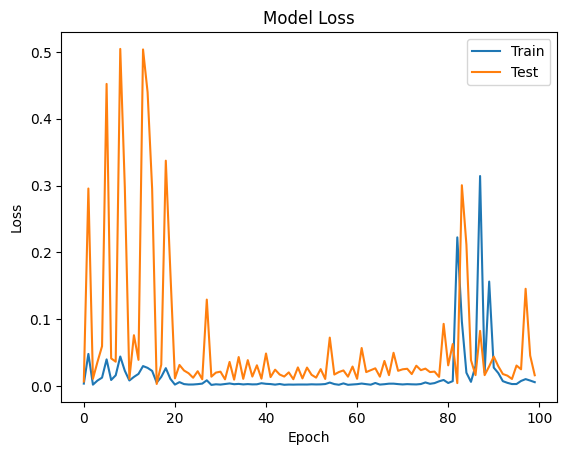

In [15]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame
scaler = MinMaxScaler(feature_range=(0, 1))
dg = pd.DataFrame(scaler.fit_transform(df[["High", "Low", "Open", "Close", "Volume", "mv_avg_short", "mv_avg_long"]].values))
dg0 = dg[[0, 1, 2, 3, 4, 5]]

window = 4
dfw = create_window(dg0, window)

X_dfw = np.reshape(dfw.values, (dfw.shape[0], window + 1, 6))

y_dfw = np.array(dg[6][window:])  # The Fix

# Adjust mtest based on the new shape of your data
mtest = 600

X_trainw, X_testw, y_trainw, y_testw = train_test_split(X_dfw, y_dfw, test_size=mtest, shuffle=False)

def model_lstm(window, features):
    model = Sequential()
    model.add(LSTM(300, input_shape=(window, features), return_sequences=True))
    model.add(Dropout(0.2))  # Add dropout layer with a dropout rate (fraction of input units to drop)
    model.add(LSTM(200, input_shape=(window, features), return_sequences=False))
    model.add(Dropout(0.2))  # Add dropout layer with a dropout rate
    model.add(Dense(100, kernel_initializer='uniform', activation='relu'))
    model.add(Dropout(0.2))  # Add dropout layer with a dropout rate
    model.add(Dense(1, kernel_initializer='uniform', activation='relu'))
    model.compile(loss='mse', optimizer='adam')

    return model

model = model_lstm(window + 1, 6)
history = model.fit(X_trainw, y_trainw, epochs=100, batch_size=200, validation_data=(X_testw, y_testw), \
                    verbose=1, callbacks=[], shuffle=False)  # Batch size should be no more than the square root of the # of training rows

# Plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()



In [30]:
y_pr=model.predict(X_trainw)

19/19 [==============================] - 1s 61ms/step


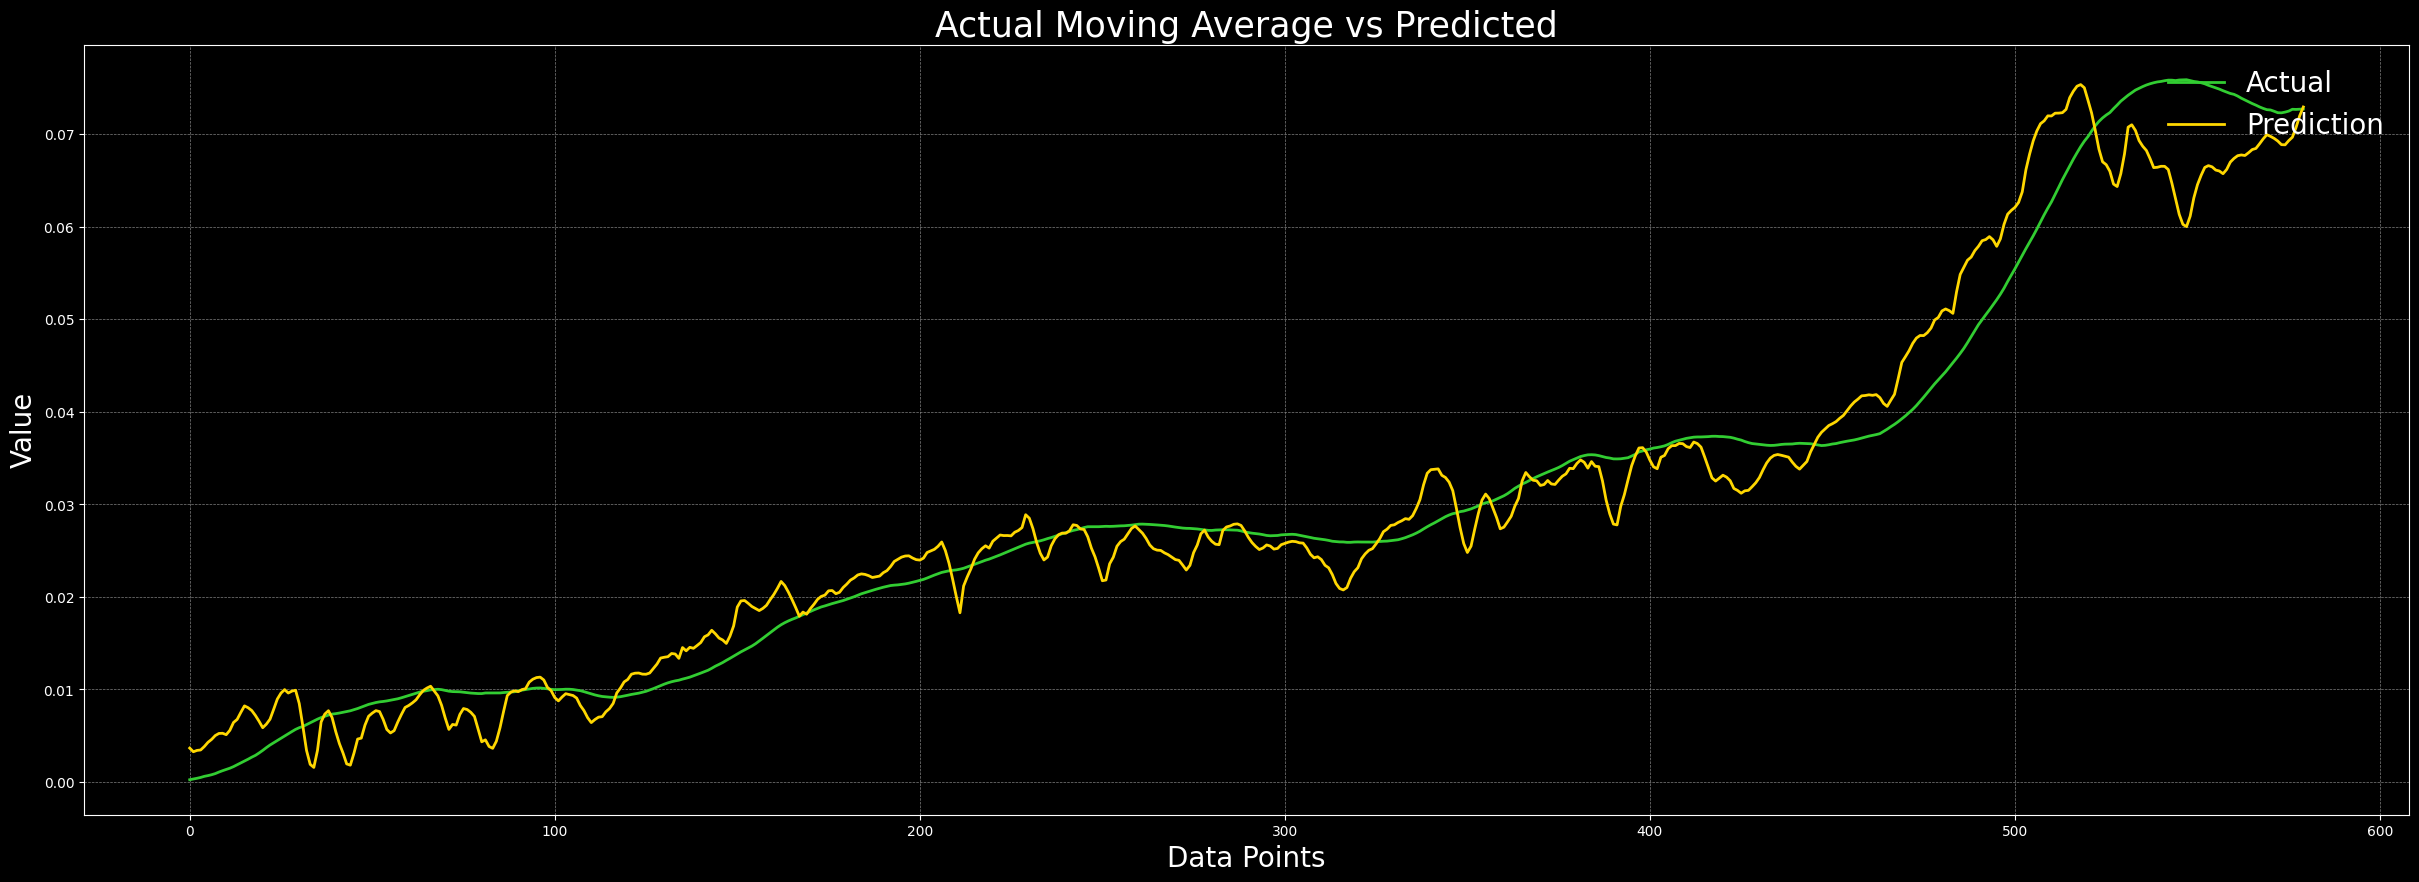

In [31]:
import matplotlib.pyplot as plt
import matplotlib.style as style

# Set the style to a dark theme
style.use('dark_background')

# Assuming y_trainw and y_pr are your actual and predicted values
plt.figure(figsize=(30, 10))
plt.plot(y_trainw, label='Actual', color='limegreen', linewidth=2)  # Customize the color and linewidth as needed
plt.plot(y_pr, label='Prediction', color='gold', linewidth=2)  # Customize the color and linewidth as needed

# Set title and labels with light text for better visibility
plt.title('Actual Moving Average vs Predicted', fontsize=25, color='white')
plt.xlabel('Data Points', fontsize=20, color='white')
plt.ylabel('Value', fontsize=20, color='white')

# Add legend with light text
plt.legend(fontsize=20, loc='upper right', frameon=False, facecolor='none', edgecolor='none', labelcolor='white')

# Add grid lines
plt.grid(axis='both', color='gray', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()


In [19]:
from sklearn.metrics import mean_squared_error, r2_score


# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_testw, y_pr)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate other evaluation metrics as needed
# For example, you can use R-squared (R2) score
r2 = r2_score(y_testw, y_pr)
print(f'R-squared (R2) Score: {r2}')

Mean Squared Error (MSE): 0.015798512644098678
R-squared (R2) Score: -1.435597409391061


In [23]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Assuming 'df' is your DataFrame
scaler = MinMaxScaler(feature_range=(0, 1))
dg = pd.DataFrame(scaler.fit_transform(df[["High", "Low", "Open", "Close", "Volume", "mv_avg_short", "mv_avg_long"]].values))
dg0 = dg[[0, 1, 2, 3, 4, 5]]

window = 4
dfw = create_window(dg0, window)

X_dfw = np.reshape(dfw.values, (dfw.shape[0], window + 1, 6))

y_dfw = np.array(dg[6][window:])  # The Fix

# Create TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=5)  # You can adjust the number of splits as needed

mse_scores = []  # to store MSE for each fold
r2_scores = []   # to store R2 scores for each fold

# Iterate over train-test splits
for train_index, test_index in tscv.split(X_dfw):
    X_trainw, X_testw = X_dfw[train_index], X_dfw[test_index]
    y_trainw, y_testw = y_dfw[train_index], y_dfw[test_index]

    model = model_lstm(window + 1, 6)
    history = model.fit(X_trainw, y_trainw, epochs=50, batch_size=200, validation_data=(X_testw, y_testw), \
                        verbose=1, callbacks=[], shuffle=False)

    # Make predictions on the test set
    y_pred = model.predict(X_testw)

    # Evaluate the model
    mse = mean_squared_error(y_testw, y_pred)
    r2 = r2_score(y_testw, y_pred)
    mae = mean_absolute_error(y_testw, y_pred)
    mse_scores.append(mse)
    r2_scores.append(r2)
    mae_scores.append(mae)
# Print average scores across folds
print(f'Average Mean Squared Error (MSE): {np.mean(mse_scores)}')
print(f'Average R-squared (R2) Score: {np.mean(r2_scores)}')
print(f'Average Mean Absolute Error (MAE): {np.mean(mae_scores)}')

Epoch 1/50
3/3 [==============================] - 10s 2s/step - loss: 9.4914e-04 - val_loss: 0.0031
Epoch 2/50
3/3 [==============================] - 0s 72ms/step - loss: 3.9446e-04 - val_loss: 0.0016
Epoch 3/50
3/3 [==============================] - 0s 54ms/step - loss: 3.5184e-04 - val_loss: 0.0011
Epoch 4/50
3/3 [==============================] - 0s 55ms/step - loss: 5.1653e-04 - val_loss: 0.0011
Epoch 5/50
3/3 [==============================] - 0s 44ms/step - loss: 4.8633e-04 - val_loss: 0.0014
Epoch 6/50
3/3 [==============================] - 0s 47ms/step - loss: 4.2578e-04 - val_loss: 0.0016
Epoch 7/50
3/3 [==============================] - 0s 45ms/step - loss: 3.8848e-04 - val_loss: 0.0017
Epoch 8/50
3/3 [==============================] - 0s 44ms/step - loss: 3.5396e-04 - val_loss: 0.0015
Epoch 9/50
3/3 [==============================] - 0s 46ms/step - loss: 3.2194e-04 - val_loss: 0.0013
Epoch 10/50
3/3 [==============================] - 0s 36ms/step - loss: 3.0400e-04 - val_los

NameError: name 'mae_scores' is not defined

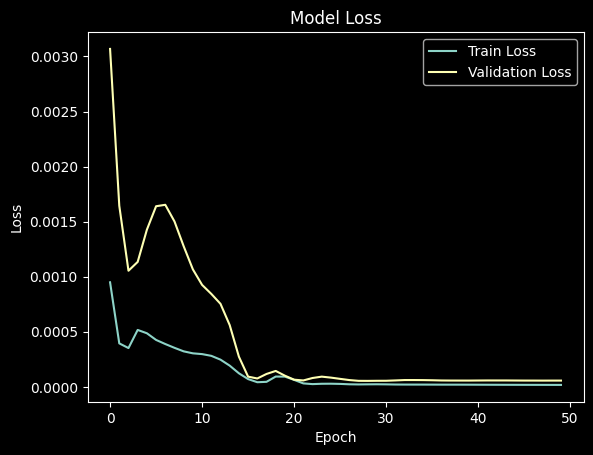

In [24]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


As we can see that after cross-validation the model training well over the epochs. We used 5 equal time series splits. 

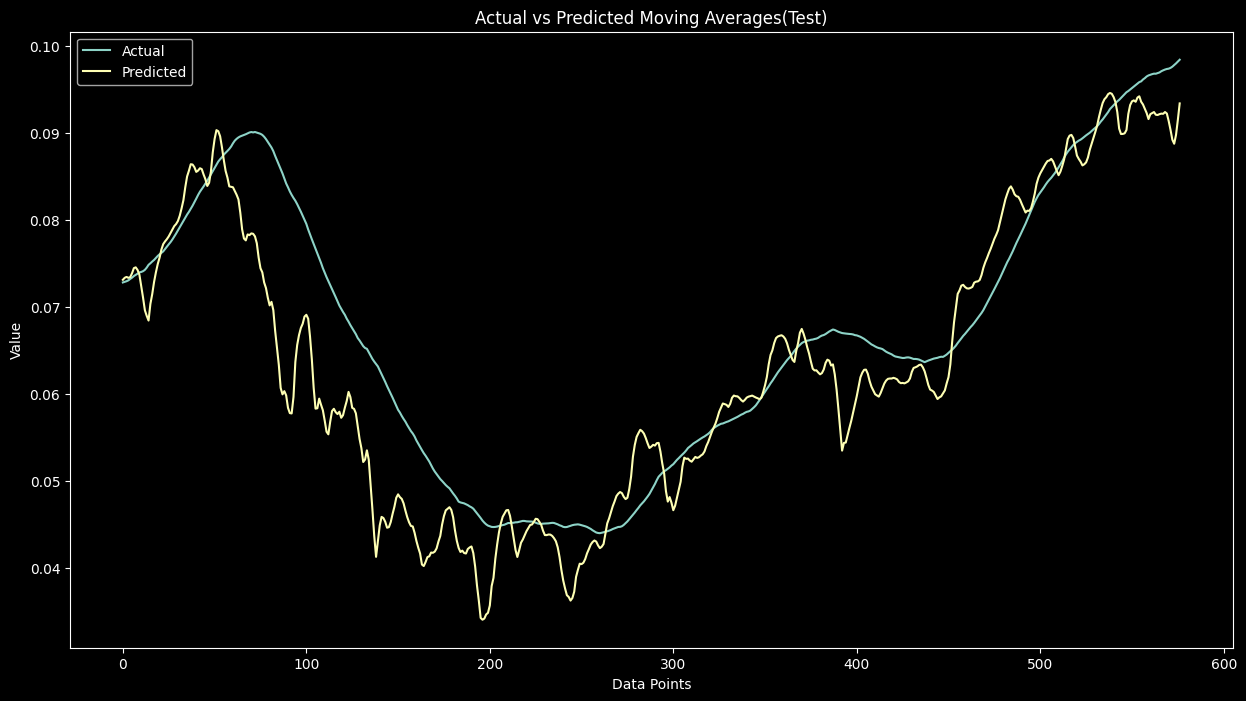

In [28]:
#y_predicted = model.predict(X_testw)
style.use('dark_background')
plt.figure(figsize=(15, 8))
plt.plot(y_testw, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Moving Averages(Test)')
plt.xlabel('Data Points')
plt.ylabel('Value')
plt.legend()
plt.show()


We can see above with the graph itself that its following the reversal in direction very well. In next line we will calculate the MSE and R2 , with R2 being our primary evaluation metric 

In [29]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_testw, y_pred)
r2 = r2_score(y_testw, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2) Score: {r2}')


Mean Squared Error (MSE): 5.652766349210566e-05
R-squared (R2) Score: 0.7805155605420723


An R2 score of 0.78 indicates that approximately 78% of the variability in the actual moving averages is accounted for by your model.
11:43
Predicting moving averages involves forecasting trends over time, and the evaluation metrics you’ve provided (MSE and R2 score) offer insights into the accuracy and explanatory power of your model in this specific context.
11:44
our benchmark without the time series split was 27 percent

In [29]:
# Evaluate the model on the test set
loss = model.evaluate(X_testw, y_testw)
print(f'Test Loss (MSE): {loss}')


19/19 [==============================] - 1s 17ms/step - loss: 0.0172
Test Loss (MSE): 0.01717752404510975


In [30]:
from sklearn.metrics import mean_squared_error

# Assuming 'model' is your trained model
y_pred = model.predict(X_testw)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_testw, y_pred)
print(f'Mean Squared Error (MSE): {mse}')


19/19 [==============================] - 0s 6ms/step
Mean Squared Error (MSE): 0.017177523648230206


In [31]:
# Use the last window days of data to predict the next day's price
last_window_data = X_dfw[-1:]
predicted_price = model.predict(last_window_data)

1/1 [==============================] - 0s 20ms/step


In [32]:
predicted_price

array([[0.8054817]], dtype=float32)

19/19 [==============================] - 0s 5ms/step


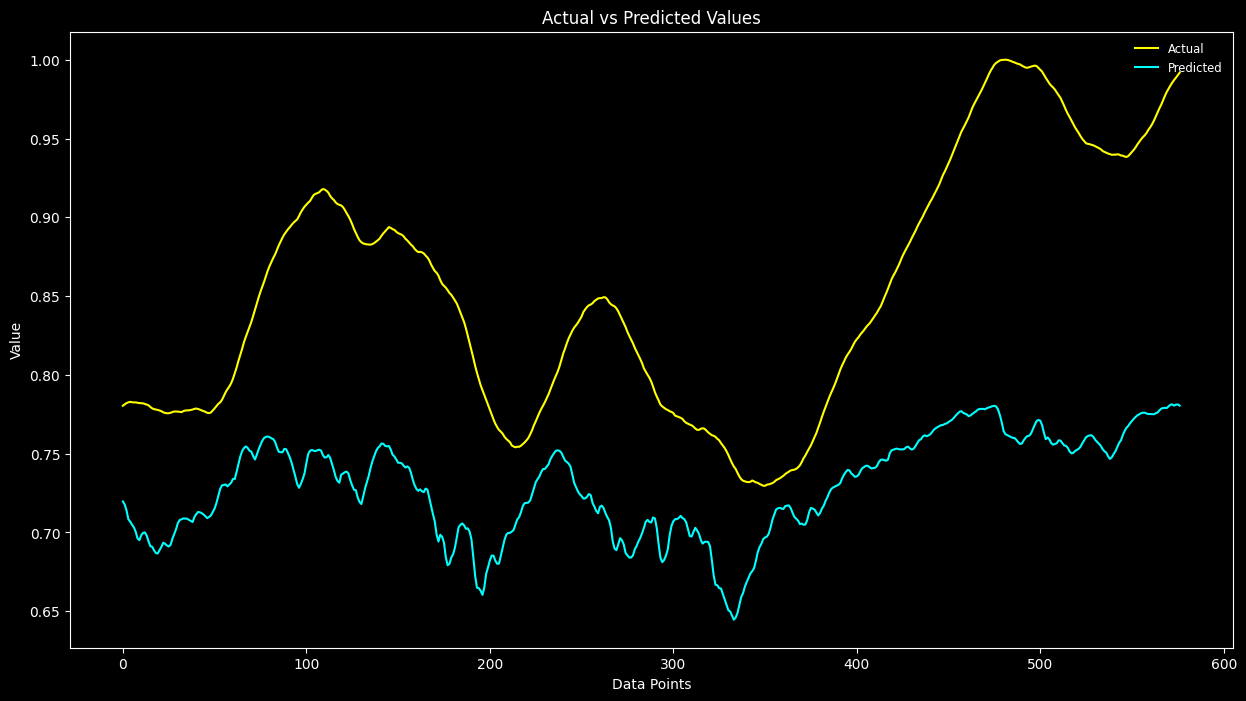

In [51]:
y_pred = model.predict(X_testw)

import matplotlib.pyplot as plt
import matplotlib.style as style

# Set the style to a dark theme
style.use('dark_background')

# Assuming y_testw and y_pred are your actual and predicted values
plt.figure(figsize=(15, 8))
plt.plot(y_testw, label='Actual', color='yellow')  # Customize the color as needed
plt.plot(y_pred, label='Predicted', color='cyan')  # Customize the color as needed

# Set title and labels with light text for better visibility
plt.title('Actual vs Predicted Values', color='white')
plt.xlabel('Data Points', color='white')
plt.ylabel('Value', color='white')

# Add legend with light text
plt.legend(fontsize='small', loc='upper right', frameon=False, facecolor='none', edgecolor='none', labelcolor='white')

# Show the plot
plt.show()



In [ ]:
X_testw
